## RFM Analysis



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python --version

Python 3.7.13


In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

!ls

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:12 http://ppa.launchpad.net/cran/libgit2/u

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/drive/MyDrive/Kaggle
#Check the present working directory using pwd command

/content/drive/MyDrive/Kaggle


In [ ]:
! kaggle datasets download -d roshansharma/online-retail

404 - Not Found


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
spark = SparkSession \
    .builder \
    .appName("Python Spark RFM example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
import pandas as pd
import numpy as np

#We can make the read operation(when DAG turns) much faster by defining the schema
schema = StructType([
  StructField("InvoiceNo",IntegerType(),True),
  StructField("StockCode",StringType(),True),
  StructField("Description",StringType(),True),
  StructField("Quantity",IntegerType(),True),
  StructField("InvoiceDate",StringType(),True),
  StructField("UnitPrice",FloatType(),True),
  StructField("CustomerID",IntegerType(),True),
  StructField("Country",StringType(),True)
])
df = spark.read.option("header","true") \
                         .format("csv") \
                         .schema(schema) \
                         .load("/content/drive/MyDrive/Kaggle/online retail.csv")

df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|1/12/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|1/12/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|1/12/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|1/12/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|1/12/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [ ]:
#The schema structures of the dataframe
df.printSchema()

root
 |-- InvoiceNo: integer (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: float (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [ ]:
#Columns in the data
df.columns

['InvoiceNo',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country']

In [ ]:
#Data Cleaning and Data Manipulation
from pyspark.sql.functions import count

#Returning the counts from all the columns to check that how many column contain how much null values(NaN values)
def my_count(df_in):
    df_in.agg( *[ count(c).alias(c) for c in df_in.columns ] ).show()
my_count(df)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   532616|   532616|     531162|  532616|     532616|   532616|    397924| 532616|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



#Handling Null Values




In [ ]:
#First going with the basic method as our dataset is sufficiently large and if the model fails to generalize good on the dataset we will use other missing vaue handling techniques
df = df.dropna(how="any")
my_count(df)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   397924|   397924|     397924|  397924|     397924|   397924|    397924| 397924|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [ ]:
#Converting InvoiceDate coulmn to UTC time stamp format(New column NewInvoiceDate Created)
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col
timeFormat = "MM/dd/yy HH:mm"
df = df.withColumn("NewInvoiceDate",to_utc_timestamp(unix_timestamp(col("InvoiceDate"),timeFormat).cast("timestamp"),"UTC"))

In [ ]:
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|     NewInvoiceDate|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|1/12/2010 8:26|     2.55|     17850|United Kingdom|2010-01-12 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|1/12/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|1/12/2010 8:26|     2.75|     17850|United Kingdom|2010-01-12 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|1/12/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|1/12/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|
+---------+-----

In [ ]:
#Calculating the total price
#For Calculating the monetary value we will be requiring the total amount that the customer has spent(so we need to get the price spent  by customer and which is equal to Quantity*unit_price_of_quantity)
from pyspark.sql.functions import round
df = df.withColumn("TotalPrice",round(df.Quantity*df.UnitPrice,2))
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+----------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|     NewInvoiceDate|TotalPrice|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|1/12/2010 8:26|     2.55|     17850|United Kingdom|2010-01-12 08:26:00|      15.3|
|   536365|    71053| WHITE METAL LANTERN|       6|1/12/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|     20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|1/12/2010 8:26|     2.75|     17850|United Kingdom|2010-01-12 08:26:00|      22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|1/12/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|     20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|1/12/2010 8

In [ ]:
#Calculating the time difference
from pyspark.sql.functions import mean,min,max,sum,datediff,to_date
date_max = df.select(max("NewInvoiceDate")).toPandas()
current = to_utc_timestamp(unix_timestamp(lit(str(date_max.iloc[0][0])),"yy-MM-dd HH:mm").cast("timestamp"),"UTC")

#Calculating the Duration(Duration is another important attribute for RFM analysis which tell how often did customer purchase)(From how much time he hasn't purchased)
df = df.withColumn("Duration",datediff(lit(current),"NewInvoiceDate"))
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+----------+--------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|     NewInvoiceDate|TotalPrice|Duration|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+----------+--------+
|   536365|   85123A|WHITE HANGING HEA...|       6|1/12/2010 8:26|     2.55|     17850|United Kingdom|2010-01-12 08:26:00|      15.3|     697|
|   536365|    71053| WHITE METAL LANTERN|       6|1/12/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|     20.34|     697|
|   536365|   84406B|CREAM CUPID HEART...|       8|1/12/2010 8:26|     2.75|     17850|United Kingdom|2010-01-12 08:26:00|      22.0|     697|
|   536365|   84029G|KNITTED UNION FLA...|       6|1/12/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|     20.34|     697|

###In this step we have build our RFM feature matrix and hence completed our first step of RFM analysis

In [ ]:
#Building Recency,Frequency and Monetary attribute corresponding to the customers ID(Customers)
recency = df.groupBy("CustomerID").agg(min("Duration").alias("Recency"))
frequency = df.groupBy("CustomerID","InvoiceNo").count().groupBy("CustomerID").agg(count("*").alias("Frequency"))
monetary = df.groupBy("CustomerID").agg(round(sum("TotalPrice"), 2).alias("Monetary"))
rfm = recency.join(frequency,"CustomerID",how ="inner").join(monetary,"CustomerID",how ="inner")

rfm.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15727|      9|        7| 5178.96|
|     16574|   null|        1|  451.44|
|     17420|    697|        3|  598.83|
|     13285|    337|        4| 2709.12|
|     15619|   null|        1|   336.4|
+----------+-------+---------+--------+
only showing top 5 rows



In [ ]:
rfm = rfm.dropna()

In [ ]:
rfm.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15727|      9|        7| 5178.96|
|     17420|    697|        3|  598.83|
|     13285|    337|        4| 2709.12|
|     17389|      9|       34|31833.68|
|     16503|     96|        4| 1431.93|
+----------+-------+---------+--------+
only showing top 5 rows



Now our next step will be determination of cutting points for each feature

RFM Segamentation
Determine the cutting points for each attribute.Cutting points can be mainly inferenced from business point of view.

In [ ]:
#Use obove function describe_pd or either use this below piece of code for short statistical inference
cols = ["Recency","Frequency","Monetary"]
rfm.select(cols).describe().show()

+-------+------------------+------------------+------------------+
|summary|           Recency|         Frequency|          Monetary|
+-------+------------------+------------------+------------------+
|  count|              2997|              2997|              2997|
|   mean|154.39005672339005|5.4724724724724725| 2681.700777444111|
| stddev|140.15565805873825| 8.991484232943673|10653.388721722633|
|    min|                 0|                 1|               6.2|
|    max|               697|               210|         280206.02|
+-------+------------------+------------------+------------------+



In [ ]:
#Using the quantile for defining the R,F,M values between 1 and 4
#According to the magnitudes we have assigned values between 1 to 4 to the attributes

def RScore(x):
  #Smaller value of x(Recency) tells us that the particular customer has done some activity(like buying something or using some product) recently and contrary larger the value of x will give some inference that customer wasn't involved in activity from a long time
  if x== None:
    return None
  elif x <= 16:
    return 1
  elif x<= 50:
    return 2
  elif x<= 143:
    return 3
  else:
    return 4

In [ ]:
def FScore(x):
  #Smaller the value of x(Frequency) tell that the customer is not involved in activities frequently and for customer with high value of x denotes that customer is involved in Frequent activities
  if x== None:
    return None
  elif x <= 1:
    return 4
  elif x <= 3:
    return 3
  elif x <= 5:
    return 2
  else:
    return 1

In [ ]:
def MScore(x):
  #Smaller the value of x(Monetary value) tells us that customer activities cost is not much(has not spent much money on buying some product etc) and contrary higher value of x denotes that customer has spent a lot of money on activities
  if x== None:
    return None
  elif x <= 293:
    return 4
  elif x <= 648:
    return 3
  elif x <= 1611:
    return 2
  else:
    return 1

In [ ]:
#A customer can have any of the permutation of these values corresponding to their activities

#For each and every value of R,F,M we will pass them through the lambda function in corresponding R_udf,F_udf,M_udf
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

R_udf = udf(lambda x: RScore(x), StringType())
F_udf = udf(lambda x: FScore(x), StringType())
M_udf = udf(lambda x: MScore(x), StringType())

In [ ]:
#RFM segamentation
from pyspark.sql.functions import concat

rfm_seg=rfm.withColumn("r_seg", R_udf("Recency"))
rfm_seg=rfm_seg.withColumn("f_seg", F_udf("Frequency"))
rfm_seg=rfm_seg.withColumn("m_seg", M_udf("Monetary"))

rfm_seg.show(5)

+----------+-------+---------+--------+-----+-----+-----+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|
+----------+-------+---------+--------+-----+-----+-----+
|     15727|      9|        7| 5178.96|    1|    1|    1|
|     17420|    697|        3|  598.83|    4|    3|    3|
|     13285|    337|        4| 2709.12|    4|    2|    1|
|     17389|      9|       34|31833.68|    1|    1|    1|
|     16503|     96|        4| 1431.93|    3|    2|    2|
+----------+-------+---------+--------+-----+-----+-----+
only showing top 5 rows



##Next will be determination of RFM score and corresponding business value

In [ ]:
col_list=["r_seg","f_seg","m_seg"]

#RFM score is nothing but the concatenated R,F,M values
rfm_seg=rfm_seg.withColumn("RFMScore",concat(*col_list))
rfm_seg.sort("RFMScore").show(20)

# df_load.write.format('mongo')\ .mode('overwrite')\ .option('spark.mongodb.output.uri', 'mongodb://127.0.0.1:27017/Quake.quakes').save()

+----------+-------+---------+--------+-----+-----+-----+--------+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|RFMScore|
+----------+-------+---------+--------+-----+-----+-----+--------+
|     14364|      5|        8| 3717.35|    1|    1|    1|     111|
|     16057|      5|        7| 2263.12|    1|    1|    1|     111|
|     16145|      3|       11| 3799.49|    1|    1|    1|     111|
|     15974|      5|        7| 3442.15|    1|    1|    1|     111|
|     17685|      1|        7| 3191.53|    1|    1|    1|     111|
|     12709|      0|       15| 9736.52|    1|    1|    1|     111|
|     13488|      9|       13| 8968.31|    1|    1|    1|     111|
|     16839|      1|       34|16594.35|    1|    1|    1|     111|
|     17811|      1|       39| 7837.73|    1|    1|    1|     111|
|     17071|      1|        9| 2429.03|    1|    1|    1|     111|
|     15727|      9|        7| 5178.96|    1|    1|    1|     111|
|     12757|      5|       13|  7857.1|    1|    1|    1|     

In [ ]:
print(type(rfm_seg))

<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
rfm_seg.toPandas().to_csv('mycsv.csv')

In [ ]:
#Statistical summary for each RFM score(Mapping of RFM score against average R,F,M values)
rfm_seg.groupBy("RFMScore").agg({"Recency":"mean","Frequency":"mean","Monetary":"mean"} ).sort(["RFMScore"]).show(5)

+--------+------------------+------------------+------------------+
|RFMScore|      avg(Recency)|     avg(Monetary)|    avg(Frequency)|
+--------+------------------+------------------+------------------+
|     111|3.3160919540229883|12671.901494252872|21.488505747126435|
|     112|               3.2|         1275.4672|              8.36|
|     121|3.2962962962962963| 2354.196296296296|  4.62962962962963|
|     122| 3.119047619047619|1119.3678571428568| 4.285714285714286|
|     123|               3.0|           538.286|               4.2|
+--------+------------------+------------------+------------------+
only showing top 5 rows



# Build feature matrix

In [ ]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

def transData(data):
    return data.rdd.map(lambda r: [r[0],Vectors.dense(r[1:])]).toDF(['CustomerID','rfm'])

In [ ]:
transformed= transData(rfm)
transformed.show(5)


+----------+-------------------+
|CustomerID|                rfm|
+----------+-------------------+
|     15727|  [9.0,7.0,5178.96]|
|     17420| [697.0,3.0,598.83]|
|     13285|[337.0,4.0,2709.12]|
|     17389|[9.0,34.0,31833.68]|
|     16503| [96.0,4.0,1431.93]|
+----------+-------------------+
only showing top 5 rows



# Scaler the feature matrix

In [ ]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="rfm",\
         outputCol="features")
scalerModel =  scaler.fit(transformed)
scaledData = scalerModel.transform(transformed)
scaledData.show(5,False)

+----------+-------------------+---------------------------------------------------------------+
|CustomerID|rfm                |features                                                       |
+----------+-------------------+---------------------------------------------------------------+
|15727     |[9.0,7.0,5178.96]  |[0.01291248206599713,0.028708133971291867,0.018460968318966087]|
|17420     |[697.0,3.0,598.83] |[1.0,0.009569377990430622,0.0021150263408449012]               |
|13285     |[337.0,4.0,2709.12]|[0.4835007173601148,0.014354066985645933,0.009646401628666285] |
|17389     |[9.0,34.0,31833.68]|[0.01291248206599713,0.15789473684210525,0.11358850979989922]  |
|16503     |[96.0,4.0,1431.93] |[0.13773314203730272,0.014354066985645933,0.005088261655557095]|
+----------+-------------------+---------------------------------------------------------------+
only showing top 5 rows



# K-means clustering 

In [ ]:
#PySpark libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from functools import reduce  # For Python 3.x

from pyspark.ml.clustering import KMeans
#from pyspark.ml.evaluation import ClusteringEvaluator  # requires Spark 2.4 or later

import numpy as np
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("features")\
            .setPredictionCol("cluster")

    model = kmeans.fit(scaledData)
    cost[k] = model.computeCost(scaledData) # requires Spark 2.0 or later

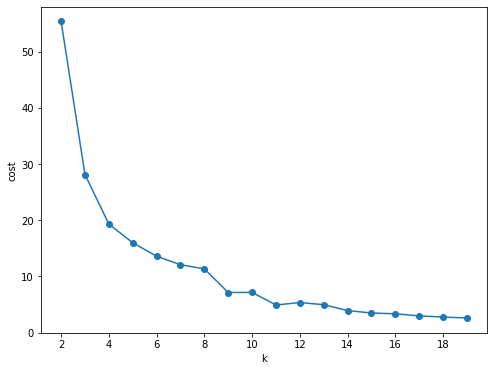

In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20], marker = "o")
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()